# From Bayes to BERT: Classification Approaches in NLP
***
[Alejandro Ciuba](https://alejandrociuba.github.io), alejandrociuba@pitt.edu
***
## Summary

This presentation looks at the various ways we can build and develop NLP pipelines for text classification tasks like author identification and sentiment analysis. The presentation plans to cover the following approaches:

1. [Simple Knowledge Bases](#simple-knowledge-base)
2. [Naive Bayes Classifier](#naive-bayes-classifier)
3. [K-Nearest Neighbors](#k-nearest-neighbors)
4. [Support Vector Machine](#support-vector-machines)
5. [Logistic Regression](#logistic-regression)
6. [Feed-Forward Neural Network](#feed-forward-neural-network)
7. Recurrent Neural Network
8. Long-Short Term Memory Network
9. Gated Recurrent Unit Network
10. Simple Transformer
11. HuggingFace Classifiers
***
## Necessary Imports & Setup
### General

In [156]:
# These imports are required to run the notebook
from pathlib import Path

import nltk
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Metrics

In [157]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             confusion_matrix,
                             roc_curve,)

### Preprocessing & Vectorization

In [158]:
from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfVectorizer,)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### Machine-Learning Models

In [159]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

### Deep-Learning Models

In [160]:
from collections import OrderedDict
from torch.utils.data import (Dataset, 
                              DataLoader,)

import torch

import torch.nn as nn

### Ignore The Knowledge Base Implementation

The knowledge base was modified from a previous homework I did for *CS2710: Foundations in AI*, and as such I will not be uploading it to the repository. Please run this to ignore the cells that require this import

In [161]:
ALEJANDRO = True  # I'm me, lol

if ALEJANDRO:    
    from kb.Propositional_KB_agent import *

### Load The Datasets

In [162]:
PATH = "./datasets/"
df = pd.read_pickle(PATH + "dataset.pkl")

CLEANER = re.compile(r"[“”\"\\\n\t\r,\.\?\!\[\]\{\}\(\)]", re.I)

def clean(line: str) -> str: 
    return CLEANER.sub("", line.lower())

# Create a tokenized word column
df["line"] = df["line"].map(clean)
df["tokens"] = df["line"].map(nltk.word_tokenize)

df.sample(10)


,author,book,line,tokens
252782,tolstoy,anna_karenina,she’s very lovely said kitty when she was alon...,"[she, ’, s, very, lovely, said, kitty, when, s..."
97005,melville,moby_dick,unobserved he rose and glided away; while awes...,"[unobserved, he, rose, and, glided, away, ;, w..."
14569,austen,mansfield_park,the greater length of the service however i ad...,"[the, greater, length, of, the, service, howev..."
89424,melville,moby_dick,queequeg was my own inseparable twin brother; ...,"[queequeg, was, my, own, inseparable, twin, br..."
212772,tolstoy,anna_karenina,you know how she takes everything to heart,"[you, know, how, she, takes, everything, to, h..."
46072,austen,emma,whenever i see her she always curtseys and ask...,"[whenever, i, see, her, she, always, curtseys,..."
126632,melville,bartleby,i paused; then went close up to him; stooped o...,"[i, paused, ;, then, went, close, up, to, him,..."
170186,tolstoy,war_and_peace,i’ll go and look for shelter,"[i, ’, ll, go, and, look, for, shelter]"
237382,tolstoy,anna_karenina,and as far as alexey alexandrovitch was concer...,"[and, as, far, as, alexey, alexandrovitch, was..."
10203,austen,sense_and_sensibility,i have entered many a shop to avoid your sight...,"[i, have, entered, many, a, shop, to, avoid, y..."


### Useful Helper Functions

In [163]:
def get_metrics(targets, predictions):

    acc = accuracy_score(y_true=targets, y_pred=predictions)
    prec = precision_score(y_true=targets, y_pred=predictions, average="macro")
    rec = recall_score(y_true=targets, y_pred=predictions, average="macro")
    f1 = f1_score(y_true=targets, y_pred=predictions, average="macro")
    conf = confusion_matrix(y_true=targets, y_pred=predictions)

    return acc, prec, rec, f1, conf

In [164]:
def plot_confusion_matrix(cm, labels):   
    sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="Reds", 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.show()

In [165]:
def plot_calibration_curve(y_test, probs, bins = 10, label = ""):
    # Modified from geeksforgeeks https://www.geeksforgeeks.org/calibration-curves/
    # Creating Calibration Curve
    x, y = calibration_curve(y_test, probs, n_bins = 10)
    
    # Plot calibration curve
    
    # Plot perfectly calibrated
    plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
    
    # Plot model's calibration curve
    plt.plot(y, x, marker = '.', label = label)
    
    leg = plt.legend(loc = 'upper left')
    plt.xlabel('Average Predicted Probability in each bin')
    plt.ylabel('Ratio of positives')
    plt.show()

In [166]:
def plot_roc_curve(y_test, probs, label=""):
    # https://medium.com/@shuv.sdr/na%C3%AFve-bayes-classification-in-python-f869c2e0dbf1
    # Plot AUC/ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, probs)

    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(fpr, tpr, label=label, color = 'firebrick')
    ax.set_title('ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    plt.box(False)
    ax.legend()

***
## Simple Knowledge Base

While not necessarily used for classification, knowledge bases are a way to represent given rules (implications [`p -> q`]) and facts (literals [`p`]) about a *domain of discourse,* a group of objects. From these rules and facts, we can algorithmically deduce new rules (forward chaining) or prove new theorems (backward chaining).

In [167]:
# Get all the sentences for Emma and Moby Dick
if ALEJANDRO:
    kb_df = df[(df.book == "emma") | (df.book == "moby_dick")]
    kb_df.sample(10)

In [168]:
# Define the rules for Jane Austen and Herman Melville
if ALEJANDRO:
    austen = {'Emma', 'Harriet', 'Weston', 'Knightley', 
            'Elton','Woodhouse', 'Jane', 'Fairfax', 
            'Churchill', 'Frank', 'Hartfield', 'Bates', 
            'Highbury', 'Perry', 'Cole', 'Goddard', 
            'Campbell', 'Donwell', 'Dixon', 'Taylor',}

    melville = {'Ahab','Queequeg', 'Pequod', 'Bildad', 
                'Stubb', 'Starbuck', 'Peleg', 'Pip', 
                'Tashtego', 'Charley'}

    austen = [Rule(f"R{i}", [name.lower()], "emma") for i, name in enumerate(austen)]
    melville = [Rule(f"R{i}", [name.lower()], "moby_dick") for i, name in enumerate(melville)]

    kb_austen = KB(init_RB=austen)
    kb_melville = KB(init_RB=melville)

In [169]:
if ALEJANDRO:
    kb_austen.print_RB()

R0
If: ['hartfield']
Then: emma
 
R1
If: ['taylor']
Then: emma
 
R2
If: ['woodhouse']
Then: emma
 
R3
If: ['frank']
Then: emma
 
R4
If: ['highbury']
Then: emma
 
R5
If: ['knightley']
Then: emma
 
R6
If: ['jane']
Then: emma
 
R7
If: ['churchill']
Then: emma
 
R8
If: ['dixon']
Then: emma
 
R9
If: ['weston']
Then: emma
 
R10
If: ['perry']
Then: emma
 
R11
If: ['bates']
Then: emma
 
R12
If: ['fairfax']
Then: emma
 
R13
If: ['campbell']
Then: emma
 
R14
If: ['harriet']
Then: emma
 
R15
If: ['cole']
Then: emma
 
R16
If: ['goddard']
Then: emma
 
R17
If: ['elton']
Then: emma
 
R18
If: ['emma']
Then: emma
 
R19
If: ['donwell']
Then: emma
 


Since our knowledge base is simple, this becomes a simple check on the rules. No forward or backward chaining necessary.

In [170]:
if ALEJANDRO:
    def predict(tokens):

        # Reset the facts each time
        kb_austen.reset_FB()
        kb_melville.reset_FB()

        kb_austen.add_facts(tokens)
        kb_melville.add_facts(tokens)

        if forwardchain(kb_austen, "emma"):
            return "emma"
        elif forwardchain(kb_melville, "moby_dick"):
            return "moby_dick"
        else:
            return "no_answer"
            
    kb_df["prediction"] = kb_df["tokens"].map(predict)

    kb_df.sample(10)

/tmp/ipykernel_22057/2958747777.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kb_df["prediction"] = kb_df["tokens"].map(predict)


/home/computer_cat/miniconda3/envs/pyling/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.2639
Precision: 0.6662
Recall: 0.1961
F1 Score: 0.2888


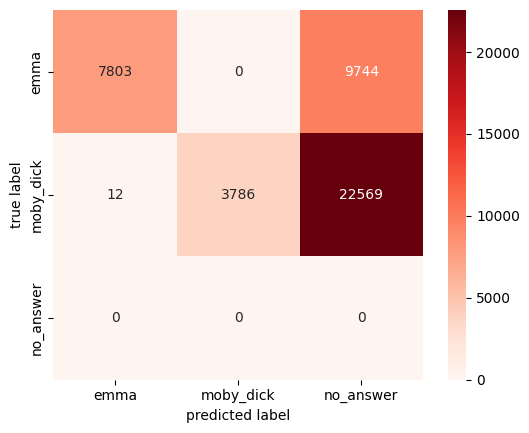

In [171]:
# Check the metrics
if ALEJANDRO:

    acc, prec, rec, f1, conf = get_metrics(targets=kb_df["book"], predictions=kb_df["prediction"])
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    plot_confusion_matrix(conf, labels=["emma", "moby_dick", "no_answer"])

***
## Naive Bayes Classifier
The Naive Bayes Classifier uses Bayes' rule to predict if a given string of text is one of two classes.

$$P(\mathrm{tag} \vert \mathrm{words}) = \frac{P(\mathrm{words} \vert \mathrm{tag}) \times P(\mathrm{tag})}{P(\mathrm{words})}$$

But what exactly are the $\mathrm{words}$ in this case? Sure, we could use the raw counts of each word, but that might not give us enough information. NBC assumes *feature independence* and that the features are unordered (*bag of words*) meaning it does not consider how the probability changes as more words are added. We want words that appear more to have more weight, and we want to capture something about the relationship between these words. This is *feature engineering.*

First, let's get our data in a simpler format. Let's start with turning our labels (authors and books) into numbers!

In [172]:
authors = LabelEncoder()
df["author_label"] = authors.fit_transform(df.author)

books = LabelEncoder()
df["book_label"] = authors.fit_transform(df.book)

df.sample(2)

,author,book,line,tokens,author_label,book_label
110873,melville,the_condifence_man,in the press as in the sun resides my dear cha...,"[in, the, press, as, in, the, sun, resides, my...",1,10
64949,melville,redburn,what under heaven it was made of that it had s...,"[what, under, heaven, it, was, made, of, that,...",1,8


First, let's just predict between Jane Austen and Herman Melville. We need to filter our dataset for only these two authors and then create a training-testing split!

In [213]:
nb1_df = df[(df.author == "austen") | (df.author == "melville")]

X_train, X_test, y_train, y_test = train_test_split(nb1_df["line"].to_list(), nb1_df["author_label"].to_list(), train_size=0.7)

print(X_train[0])
print(y_train[0])

print(len(X_train), len(X_test))

mrs elton had undoubtedly the advantage at this time in vanity completely gratified; for though she had intended to begin with frank churchill she could not lose by the change
0
88691 38011


To start off, let's use simple *count-based features*. This means a word's numerical representation is simply the number of times it appears in the dataset.

In [174]:
example = CountVectorizer(max_features=10, max_df=0.7, ngram_range=(1, 3), stop_words="english")
counts = example.fit_transform(X_train)

print(counts.shape)
print(example.vocabulary_)

(88691, 10)
{'like': 2, 'man': 4, 'little': 3, 'good': 1, 'time': 9, 'said': 7, 'did': 0, 'mr': 5, 'think': 8, 'mrs': 6}


We can combine models and feature preprocessing via *pipelines!*

In [175]:
nb_pipe = make_pipeline(CountVectorizer(max_features=2000, max_df=0.7, ngram_range=(1, 3), stop_words="english"),
                           MultinomialNB())

nb_pipe.fit(X=X_train, y=y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.7, max_features=2000,
                                 ngram_range=(1, 3), stop_words='english')),
                ('multinomialnb', MultinomialNB())])

Let's test it to see how it performs on the training data

In [176]:
predictions = nb_pipe.predict(X_test)

Accuracy: 0.8623
Precision: 0.8661
Recall: 0.8623
F1 Score: 0.8619


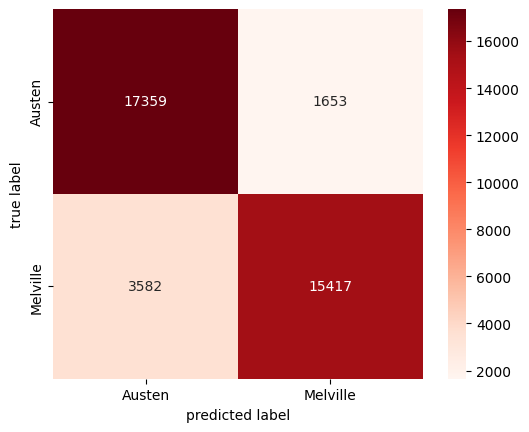

In [177]:
acc, prec, rec, f1, conf = get_metrics(targets=y_test, predictions=predictions)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

plot_confusion_matrix(conf, labels=["Austen", "Melville"])

Label metrics are good, but they don't tell us anything about the model's probability labelling. Remember, this is all ultimately based on probabilities! Sklearn hides this process from us, splitting the labels at the 0.5 threshold.

$$\mathrm{Label}(\mathrm{label}_{0}, \mathrm{label}_{1}, \mathrm{words}) = 0 \ \mathrm{if} \ (P(\mathrm{label}_{0} \vert \mathrm{words})) < 0.5 \ \mathrm{else} \ 1 $$

Let's look at the actual probabilities this time and examine the model's *calibration!*

In [178]:
prob_preds = nb_pipe.predict_proba(X_test)

print(prob_preds[0])

[2.22193817e-13 1.00000000e+00]


Let's look at the model's **calibration curve**! Essentially, the model's probabilities for a label should match the frequency we see that label in the dataset!

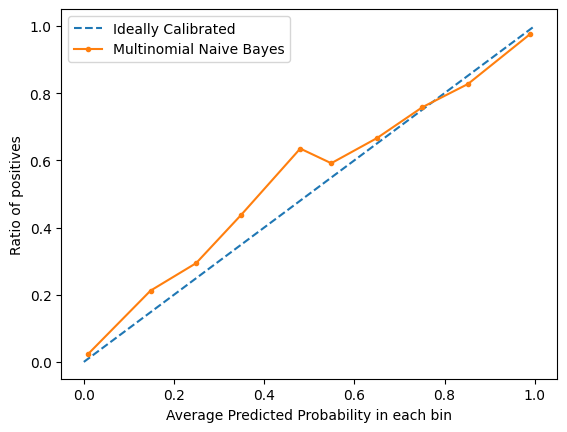

In [179]:
plot_calibration_curve(y_test, prob_preds[:, 1], label="Multinomial Naive Bayes")

Let's also look at the **Area Under the Receiver Operator Curve (AUROC)**, which tells us how our model performs at different classification thresholds!

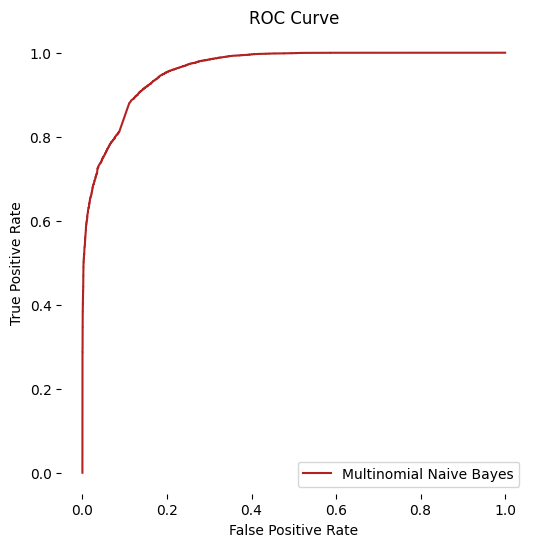

In [180]:
plot_roc_curve(y_test, prob_preds[:, 1], label="Multinomial Naive Bayes")

As we can see, our model isn't well calibrated despite its accuracy on the testing data.
***
## K-Nearest Neighbors

This method works by looking at "nearby" outputs. We get an output based on the feature weights and check what similar outputs were from our training data.

### TF-IDF Vectors

These vectors are similar to the count-based vectors from before, but now words are assigned "weight" depending on their importance. The word "dexterity" doesn't tell us much about what author it could be, but the word "Emma" or "ship" could! We also need to consider the words occurrence frequency though, if a word appears a lot, it's less useful. Thus, we get **Term-Frequency Inverse-Document Frequency**!

$$\mathrm{tf}(\mathrm{term}, \mathrm{document}) = 1 + \log(\mathrm{count}(\mathrm{term}, \mathrm{document})) \ \mathrm{if} \ \mathrm{count}(\mathrm{term}, \mathrm{document}) > 0 \ \mathrm{else} 0$$

$$idf(\mathrm{term}) = \log \left( \frac{N}{\mathrm{total \ count}(i)} \right)$$

$$tfidf(\mathrm{term}, \mathrm{document}) = \mathrm{tf}(\mathrm{term}, \mathrm{document}) \times idf(\mathrm{term})$$

Let's make K-Nearest Neighbors using TF-IDF!

In [181]:
# Make the pipeline!
k_pipe = make_pipeline(TfidfVectorizer(max_features=2500, max_df=0.7, stop_words="english", ngram_range=(1, 3)),
                       KNeighborsClassifier(n_neighbors=10))

k_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.7, max_features=2500,
                                 ngram_range=(1, 3), stop_words='english')),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=10))])

In [182]:
predictions = k_pipe.predict(X_test)

Accuracy: 0.6534
Precision: 0.7161
Recall: 0.6535
F1 Score: 0.6264


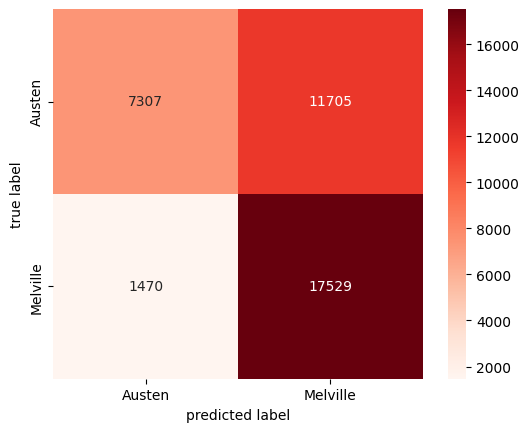

In [183]:
acc, prec, rec, f1, conf = get_metrics(targets=y_test, predictions=predictions)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

plot_confusion_matrix(conf, labels=["Austen", "Melville"])

In [184]:
prob_preds = k_pipe.predict_proba(X_test)

print(prob_preds[0])

[0.1 0.9]


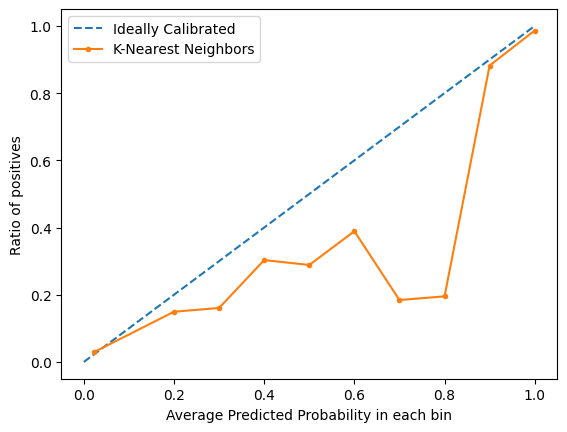

In [185]:
plot_calibration_curve(y_test, prob_preds[:, 1], label="K-Nearest Neighbors")

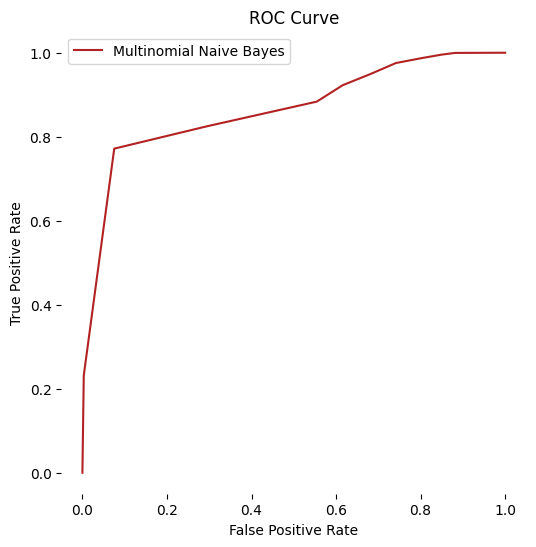

In [186]:
plot_roc_curve(y_test, prob_preds[:, 1], label="Multinomial Naive Bayes")

While our label-based metrics went down, the overall calibration is better!
***
## Support Vector Machines

My favorite machine-learning model because the name sounds cool! Also abbreviated as SVMs, these bad boys take the output space of our training data and finds a line such that it is the maximumally separates our classes; this divides the output space into two, the two regions we will use to clasify our results!

In [187]:
# Make the pipeline!
svm_pipe = make_pipeline(TfidfVectorizer(max_features=2500, max_df=0.7, stop_words="english", ngram_range=(1, 3)),
                         LinearSVC(C=1E2))

svm_pipe.fit(X_train, y_train)

/home/computer_cat/miniconda3/envs/pyling/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/computer_cat/miniconda3/envs/pyling/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.7, max_features=2500,
                                 ngram_range=(1, 3), stop_words='english')),
                ('linearsvc', LinearSVC(C=100.0))])

In [188]:
predictions = svm_pipe.predict(X_test)

Accuracy: 0.9018
Precision: 0.9021
Recall: 0.9018
F1 Score: 0.9018


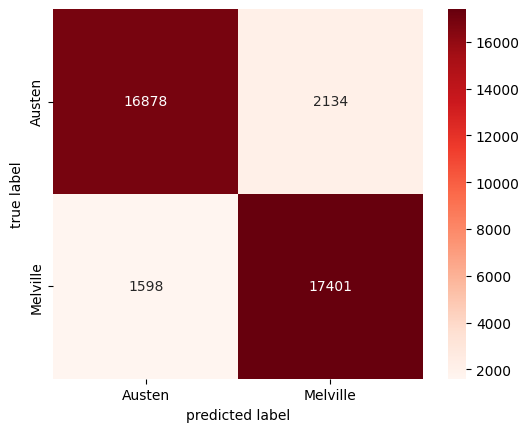

In [189]:
acc, prec, rec, f1, conf = get_metrics(targets=y_test, predictions=predictions)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

plot_confusion_matrix(conf, labels=["Austen", "Melville"])

In [190]:
# Might be some slight discrepancy due to sklearn's implementation
prob_preds = svm_pipe.decision_function(X_test)

print(prob_preds[0])

4.6078168702299545


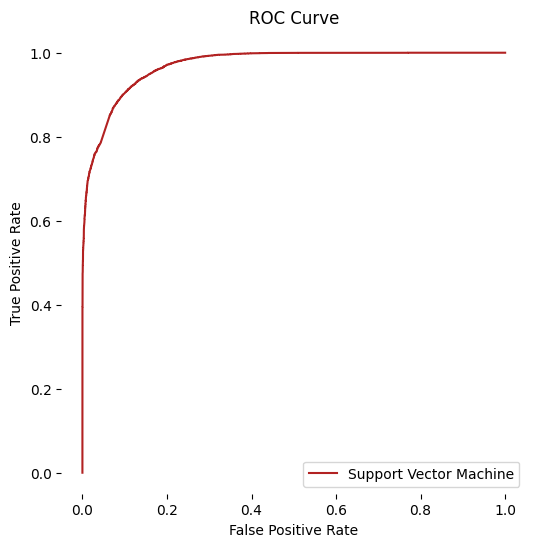

In [191]:
plot_roc_curve(y_test, prob_preds, label="Support Vector Machine")

So far, this is our best model for both calibration and accuracy!
***
## Logistic Regression

This is a very interesting classification technique. It is essentially a linear regression model with a final "layer" that transforms our real number output to be bounded within [0, 1]. This function is called the inverse log-odds (logit) function.

### Linear Regression

$$\eta = \beta_{0} + \beta_{1} x_{1} + \dots + \beta_{n} x_{n}$$

### Logit Function

$$\mathrm{logit}(\eta) = \ln \left( \frac{\eta}{1 - \eta} \right)$$

### Inverse Logit (Softmax)

$$\mathrm{softmax} = \mu = \frac{\exp(\eta)}{1 + \exp(\eta)}$$

![sigmoid](sigmoid.png)

[Link](https://math.stackexchange.com/questions/3816925/how-to-adjust-logit-functions-input-domain)

In [192]:
# Make the pipeline!
log_pipe = make_pipeline(TfidfVectorizer(max_features=2500, max_df=0.7, stop_words="english", ngram_range=(1, 3)),
                         LogisticRegression(penalty="elasticnet", l1_ratio=0.5, solver="saga"))

log_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.7, max_features=2500,
                                 ngram_range=(1, 3), stop_words='english')),
                ('logisticregression',
                 LogisticRegression(l1_ratio=0.5, penalty='elasticnet',
                                    solver='saga'))])

In [193]:
predictions = log_pipe.predict(X_test)

Accuracy: 0.9011
Precision: 0.9014
Recall: 0.9011
F1 Score: 0.9011


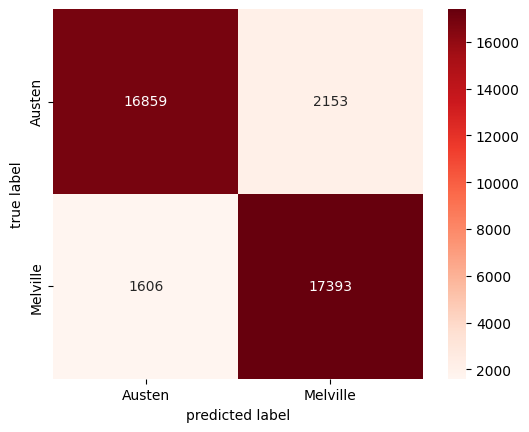

In [194]:
acc, prec, rec, f1, conf = get_metrics(targets=y_test, predictions=predictions)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

plot_confusion_matrix(conf, labels=["Austen", "Melville"])

In [195]:
prob_preds = log_pipe.predict_proba(X_test)

print(prob_preds[0])

[0.01668869 0.98331131]


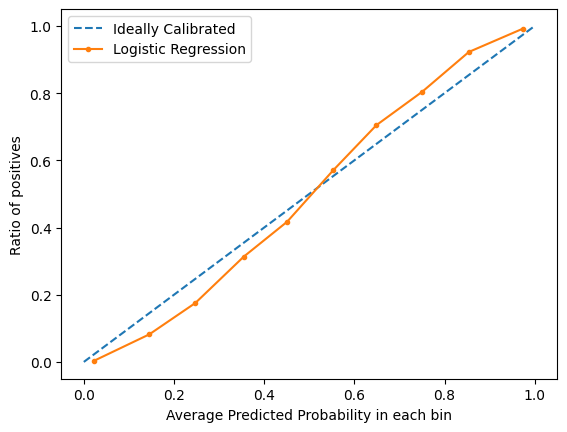

In [196]:
plot_calibration_curve(y_test, prob_preds[:, 1], label="Logistic Regression")

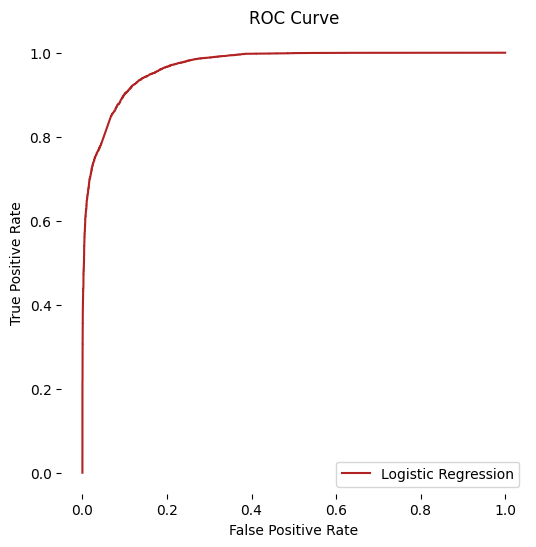

In [197]:
plot_roc_curve(y_test, prob_preds[:, 1], label="Logistic Regression")

Another good model option!
***
## Feed-Forward Neural Network

Now we're in the deep end! The deep-learning end... But anyways, these are some of the simplest deep learning models. There's a lot to talk about, so I'll leave it to the slides. Let's focus on implementing one via `torch`!

### `torch.Tensor`

These are essentially just fancy `numpy` arrays!

In [214]:
# Set the device (GPU training!)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running models on {device}")

Running models on cuda


In [215]:
# Convert to tensors; there are fancier word embedding implementations (word vectors), but let's focus on what we know
features = TfidfVectorizer(max_features=2500, max_df=0.7, stop_words="english", ngram_range=(1, 3))
X_train = features.fit_transform(X_train)
X_test = features.transform(X_test)

X_train = torch.from_numpy(X_train.toarray().astype(np.float32)).to(device)
X_test = torch.from_numpy(X_test.toarray().astype(np.float32)).to(device)
y_train = torch.from_numpy(np.array(y_train).astype(np.float32)).to(device)
y_test = torch.from_numpy(np.array(y_test).astype(np.float32)).to(device)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Sparse vector... not a lot of actual "content"
print(X_train.max(dim=1))
print(y_train)
print(X_train.shape, y_train.shape)

torch.return_types.max(
values=tensor([0.4315, 1.0000, 0.3302,  ..., 0.3877, 0.2393, 0.2962], device='cuda:0'),
indices=tensor([ 171, 1980, 1088,  ...,  751, 2274,  422], device='cuda:0'))
tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
torch.Size([88691, 2500]) torch.Size([88691])


### `nn.Sequential`

This is the easiest way to make a simple deep learning model consistent of nothing but a bunch of layers without any tinkering in the middle. Let's break down what this means:

1. We have a vector of 2500 features, `nn.Linear(2500, 5000)` takes these and outputs a vector of 5000 features.
2. We then feed that through the **ReLU** activation function.
3. We lastly take the 5000 features and output a single number with `nn.Linear(5000, 1)`.

**NOTE:** `nn.Dropout(p=0.2)` means, during training, we do not backpropagate through 20% of the weights randomly each step. This helps prevent overfitting. 

In [ ]:
model = nn.Sequential(OrderedDict([('lin1', nn.Linear(2500, 5000)),
                                   ("dropout", nn.Dropout(p=0.2)),
                                   ('relu1', nn.ReLU()),
                                   ('lin2', nn.Linear(5000, 1)),]))
model = model.to(device)

print(model)

Sequential(
  (lin1): Linear(in_features=2500, out_features=5000, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu1): ReLU()
  (lin2): Linear(in_features=5000, out_features=1, bias=True)
)


### Loss & The Optimizer

We need a way to measure how off our model is from the actual output, the **loss** function. For a binary classification task, this will be the **Binary Cross-Entropy Loss**, which is analogous to the **Bernoulli Distribution** we usually use for Logistic Regression. The next step is to figure out how to perform **Gradient Descent** each step of an epoch, this is the optimizer's job; to adjust the weights each step based on the loss based on the values gotten during back propagation.

In [ ]:
learning_rate = 1E-2
criterion = nn.BCELoss() # Bin. Cross Entropy
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

/home/computer_cat/miniconda3/envs/pyling/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Training

We train in **batches**, we run through all the training examples in small subsets. Running through all of these subsets is considered one **epoch**. This helps prevent overfitting and reduces the amount of memory needed for one epoch.

#### The Dataset

We can make batching easier by implementing a simple dataset class based on `torch.utils.data`.

In [205]:
class AuthorDataset(Dataset):

    def __init__(self):

        self.x = X_train
        self.y = y_train
        self.n = 88691

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n

dataset = AuthorDataset()
dataloader = DataLoader(dataset, batch_size=32)

### The Training Loop

In [206]:
epochs = 5
steps = len(dataset) / 32  # The batch size

for epoch in range(epochs):

    for i, (inputs, label) in enumerate(dataloader):

        # Forward
        # y_pred = model(inputs)
        print(label.shape)
        # loss = criterion(y_pred, label.unsqueeze(dim=1))

        # # Backward
        # loss.backward()

        # # Update
        # optimizer.step()
        # optimizer.zero_grad()

        # if (i + 1) % 2 == 0:
        #     print(f'epoch: {epoch}/{epochs}, step: {i}/{steps}, loss:{loss.item(): .5f}')

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'scipy.sparse._csr.csr_matrix'>